In [1]:
# 遍历文件
import tensorflow as tf

#数据检测环节，若检测到有0>矩阵第一列>矩阵第3列>1,>0>矩阵第二列>矩阵第四列>1的报错退出
import sys  
  
import math

import torch
import os
import cv2
import numpy as np
import torch.nn as nn
import datetime
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


version = "21"
# 读入图像路径
train_image_path = r"..\robotdetection-"+version+r"\train\images"
train_label_path = r"..\robotdetection-"+version+r"\train\labels"
valid_image_path = r"..\robotdetection-"+version+r"\valid\images"
valid_label_path = r"..\robotdetection-"+version+r"\valid\labels"

train_files = os.listdir(train_image_path)
train_size = len(train_files)
valid_files = os.listdir(valid_image_path)
valid_size = len(valid_files)

# N*C*H*W张量
train_data = torch.zeros(train_size, 3, 640, 640)
train_labels = torch.zeros(train_size, 4)
valid_data = torch.zeros(valid_size, 3, 640, 640)
valid_labels = torch.zeros(valid_size, 4)

for i, file in enumerate(train_files):
    # 获得图片对应的label文件名
    label = file.split(".jpg")[0]

    # 读取训练集图片
    image = cv2.imread(train_image_path + "\\" + file)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = torch.from_numpy(np.array(image, dtype=np.float16))
    label = np.loadtxt(train_label_path + "\\" + label + ".txt")
    label = torch.from_numpy(label)
    if label.shape[0] != 0:
        
        # 变为顺序
        image = image.permute(2, 0, 1)
        train_data[i] = image
        label_sliced = label[-label.shape[0]+1:] #xywh
        label_sliced_ = torch.zeros(4)
        label_sliced_[0] = label_sliced[0]-label_sliced[2]/2 #x1
        label_sliced_[2] = label_sliced[0]+label_sliced[2]/2 #y1
        label_sliced_[1] = label_sliced[1]-label_sliced[3]/2 #y2
        label_sliced_[3] = label_sliced[1]+label_sliced[3]/2 #y2
    else:
        label_sliced_ = torch.zeros(4)
       
      
    train_labels[i] = label_sliced_   
    

for i, file in enumerate(valid_files):
    # 获得图片对应的label文件名
    label = file.split(".jpg")[0]

    # 读取训练集图片
    image = cv2.imread(valid_image_path + "\\" + file)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = torch.from_numpy(np.array(image, dtype=np.float16))
    # 读取训练集物体坐标
    label = np.loadtxt(valid_label_path + "\\" + label + ".txt")
    label = torch.from_numpy(label)
    
    # 变为顺序
    image = image.permute(2, 0, 1)
    valid_data[i] = image
    label_sliced = label[-label.shape[0]+1:] 
    label_sliced_ = torch.zeros(4)
    if label.shape[0] != 0:
        label_sliced_[0] = label_sliced[0]-label_sliced[2]/2 #x1
        label_sliced_[2] = label_sliced[0]+label_sliced[2]/2 #y1
        label_sliced_[1] = label_sliced[1]-label_sliced[3]/2 #y2
        label_sliced_[3] = label_sliced[1]+label_sliced[3]/2 #y2
   
      
    valid_labels[i] = label_sliced_      



#放入dataloader中
import torch.utils.data as Data
train_batch_size = 16
valid_batch_size = 16
train_Dataset = Data.TensorDataset(train_data,train_labels)
valid_Dataset = Data.TensorDataset(valid_data,valid_labels)

train_loader = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=train_Dataset,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=True
)
valid_loader = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=valid_Dataset,
    batch_size=valid_batch_size,
    shuffle=True,
    drop_last=True
)


C:\Users\29777\AppData\Local\Temp\ipykernel_29148\2149840463.py:46: UserWarning: loadtxt: input contained no data: "..\robotdetection-21\train\labels\105_jpg.rf.0668ac821410ad8e9fe5f6a47c50ce80.txt"
  label = np.loadtxt(train_label_path + "\\" + label + ".txt")
C:\Users\29777\AppData\Local\Temp\ipykernel_29148\2149840463.py:46: UserWarning: loadtxt: input contained no data: "..\robotdetection-21\train\labels\106_jpg.rf.b0b126a642bedfe43e7007f5c6d55446.txt"
  label = np.loadtxt(train_label_path + "\\" + label + ".txt")
C:\Users\29777\AppData\Local\Temp\ipykernel_29148\2149840463.py:46: UserWarning: loadtxt: input contained no data: "..\robotdetection-21\train\labels\107_jpg.rf.5131127d1a9fc1b1cc5f07e429c208ee.txt"
  label = np.loadtxt(train_label_path + "\\" + label + ".txt")
C:\Users\29777\AppData\Local\Temp\ipykernel_29148\2149840463.py:46: UserWarning: loadtxt: input contained no data: "..\robotdetection-21\train\labels\107_jpg.rf.f43e95b5136de3406897eadb535cdf58.txt"
  label = np.lo

0.2554498704580161


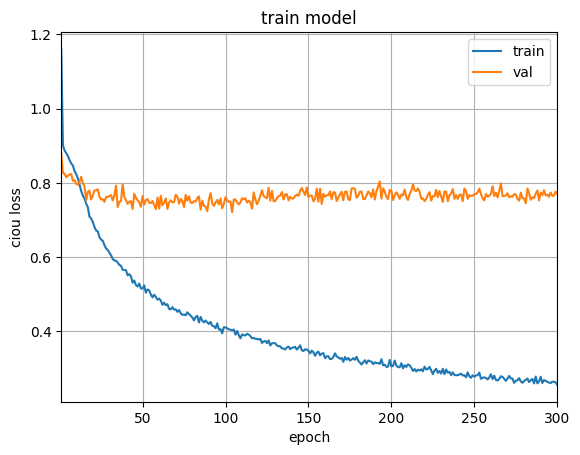

In [2]:

from IPython.display import clear_output
import math
import sys
import torch.nn.functional as F
import torchvision.ops.giou_loss as giou
import torchvision.ops.ciou_loss as ciou
from model_csp3 import Net
import pickle

def initialize_model(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

def epoch_loss(outputs,train_labels):
    cordinate_pred = outputs #n_batches*10*4
    cordinate_label = train_labels
    ciou_loss = ciou.complete_box_iou_loss(cordinate_pred,cordinate_label,reduction="sum")
    return ciou_loss
            
#保存训练的模型和标签
def training_loop(model, n_epochs, optimizer, loss_fn,train_loder,valid_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        loss_val = 0
        count_t = 0
        count_v = 0
        for imgs_t,labels_t in train_loder:
            imgs_t = imgs_t.to(device=device)
            labels_t = labels_t.to(device=device)
            outputs_t = model(imgs_t) #output_t (batchsize,10,5)
            loss_t = loss_fn(outputs_t,labels_t)
            
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            count_t += 1  
            loss_train += loss_t.item()/train_batch_size/(math.floor(train_size/train_batch_size))
            
        
        for imgs_v,labels_v in valid_loader:
            imgs_v = imgs_v.to(device=device)
            labels_v = labels_v.to(device=device)
            outputs_v = model(imgs_v)
            loss_v = loss_fn(outputs_v,labels_v)
            loss_val += loss_v.item()/valid_batch_size/(math.floor(valid_size/valid_batch_size))
            count_v += 1

        loss_val_l.append(loss_val)
        loss_train_l.append(loss_train)
        print(loss_train)
        plt.plot(range(1, epoch+1),loss_train_l,label="train")
        plt.plot(range(1, epoch+1),loss_val_l,label="val")
        plt.xlabel("epoch")
        plt.ylabel("ciou loss")
        plt.xlim((1,n_epochs))
        plt.legend(['train','val'])
        plt.title('train model')
        plt.grid(True)
        plt.show()
        clear_output(wait=True) 
      
# 训练模型
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    loss_val_l = []
    loss_train_l = []
    x = []
    # fig, ax = plt.subplots(figsize=(6, 4), dpi=600)  
    device = 0
    # model = Net().to(device)
    model = torch.load("model_csp3_800.pth")
    initialize_model(model)
    # optimizer = optim.SGD(model.parameters(),lr=1e-8)
    optimizer = optim.Adam(model.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    loss_fn = epoch_loss
    n_epochs = 300
    try:
        training_loop(model=model, n_epochs=n_epochs, optimizer=optimizer, loss_fn=loss_fn,train_loder=train_loader,valid_loader=valid_loader)
    finally:
        torch.save(model,"model_csp3_1000.pth")
        with open('model_csp3_1000_t.pkl', 'wb') as f:
            pickle.dump(loss_train_l, f)
        with open('model_csp3_1000_v.pkl', 'wb') as f:
            pickle.dump(loss_val_l, f)

In [3]:
print(model.parameters().__sizeof__())

88
